# Groupby and Arrest Data

In our merging exercises, we examined the relationship between county-level violent arrest totals and county-level drug arrest totals. In those exercises, you were given a dataset that provided you with county-level arrest totals. But that's not actually how the data is provided by the state of California. This week we will work with the *raw* California arrest data, which is not organized by county or even county-year. 



## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_groupby.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex4_num_rows",
    "ex5_collapsed_vars",
    "ex7_alameda_1980_share_violent_arrestees_black",
    "ex11_white_drug_share",
    "ex11_black_drug_share",
    "ex12_proportionate",
}
```


### Submission Limits

Please remember that you are **only allowed three submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.

### Exercise 1

Import the raw California arrest data from the State Attorney General's office. Please use [this link](https://github.com/nickeubank/MIDS_Data/blob/master/OnlineArrestData1980-2021.csv) (the original is here [here](https://openjustice.doj.ca.gov/data), but they keep updating it and I get tired of updating solutions, so... please use my copy!)

In [1]:
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)


arrests = pd.read_csv(
    "https://github.com/nickeubank/MIDS_Data/"
    "raw/master/OnlineArrestData1980-2021.csv"
)

In [2]:
arrests.shape

(102245, 13)

In [3]:
arrests.head()

,YEAR,GENDER,RACE,AGE_GROUP,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL
0,1980,Male,Black,Under 18,Alameda County,505,1351,188,26,79,2149,2286,295
1,1980,Male,Black,18 to 19,Alameda County,205,465,183,8,48,909,1333,0
2,1980,Male,Black,20 to 29,Alameda County,949,1593,606,27,178,3353,7974,0
3,1980,Male,Black,30 to 39,Alameda County,450,755,241,18,110,1574,4876,0
4,1980,Male,Black,40 to 69,Alameda County,172,218,117,11,66,584,3836,0


In [4]:
arrests.RACE.value_counts()

RACE
White       28621
Hispanic    25629
Other       25143
Black       22852
Name: count, dtype: int64

In [5]:
arrests.AGE_GROUP.value_counts()

AGE_GROUP
20 to 29       18801
30 to 39       18612
40 to 69       18437
Under 18       17488
18 to 19       17231
70 and over    11676
Name: count, dtype: int64

## Learning the Group Structure of Your Data

### Exercise 2

What is the unit of observation for this dataset? In other words, when row zero says that there were 505 arrests for `VIOLENT` crimes, what exactly is that telling you—505 arrests in 1980? 505 arrests in Alameda County?

(Please answer in Markdown)

In [6]:
arrests.iloc[0, :]

YEAR                    1980
GENDER                  Male
RACE                   Black
AGE_GROUP           Under 18
COUNTY        Alameda County
VIOLENT                  505
PROPERTY                1351
F_DRUGOFF                188
F_SEXOFF                  26
F_ALLOTHER                79
F_TOTAL                 2149
M_TOTAL                 2286
S_TOTAL                  295
Name: 0, dtype: object

> One row is the number of arrests in a given county for individuals of a given gender, race, and age category.

### Testing Your Assumptions

It's important to be able to test whether the data you are working with really is organized the way you think it is, especially when working with groupby. Let's discuss how to check your answer to Exercise 2 with the `.duplicated()` method. 

Consider the following toy data:

In [7]:
import pandas as pd

df = pd.DataFrame(
    {
        "social_security_numbers": [
            111111111,
            222222222,
            222222222,
            333333333,
            333333333,
        ],
        "second_column": ["a", "a", "a", "a", "b"],
    }
)
df

,social_security_numbers,second_column
0,111111111,a
1,222222222,a
2,222222222,a
3,333333333,a
4,333333333,b


If we want to see if there are any duplicate rows in the dataset, we can use the `.duplicated()` method:

In [8]:
df.duplicated()

0    False
1    False
2     True
3    False
4    False
dtype: bool

As you can see, `.duplicated()` looks at each row and returns `True` if it has seen the row it is looking at before. 

Notice that `.duplicted()` doesn't return `True` for *all* rows that look the same as another row in the data—it treats the first instance of a row as unique, and only tags *subsequent* repetitions as "duplicates" (You can change this behavior with the `keep` keyword argument if you want).

`.duplicated()` can also be used to test for rows that are duplicates in terms of a sub-set of columns. For example, `df.duplicated(["social_security_numbers"])` identifies rows with duplicate values of the variable `social_security_numbers`:

In [9]:
df.duplicated(["social_security_numbers"])

0    False
1    False
2     True
3    False
4     True
dtype: bool

Since `duplicated` is now only looking at `social_security_numbers` (not all values in a row), the last row is now a duplicate (because `333333333` is duplicated), where when we considered all columns, it was not a duplicate. 

### Testing with .duplicated()

`.duplicated()` can be paired with the `.any()` method to write `assert` tests to detect the presence of duplicates in our dataset and to validate our assumptions about whether certain variables uniquely identify observations in our data.

When you run `.any()` on an array of Booleans, it returns a single value of `True` if *any* entries are `True`, and a single value of `False` if *no* entries are `True`. (You can also use `.all()` to test if all entries are `False`).

Thus the command `df.duplicated(['social_security_numbers'])` will return `False` if `social_security_numbers` uniquely identifies every row in our dataset (since there are no duplicates)! But if there *are* any duplicates, it will return `True`:

In [10]:
df.duplicated(["social_security_numbers"]).any()

np.True_

So if I wanted a test that would raise an `Error` if it turned out that `social_security_numbers` *didn't* uniquely identify observations, I would combine that code with `assert not`:

```python
assert not df.duplicated(["social_security_numbers"]).any()

---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Cell In [20], line 1
----> 1 assert not df.duplicated(["social_security_numbers"]).any()

AssertionError: 
```

(which in this case raises an Error because `social_security_numbers` *isn't* unique!)

BTW, if this feels oddly familiar, that's probably because we talked about this same idea when discussing merging. A `1:1` merge is one in which the merging variables uniquely identify observations in both datasets.

### Exercise 3

Use `duplicated` to test if the variables *you* think uniquely identify rows in your data really do uniquely identify rows. If you were wrong, update your beliefs (and your code) until you have an `assert` statement that passes.

In [11]:
assert not arrests.duplicated(["YEAR", "GENDER", "RACE", "AGE_GROUP", "COUNTY"]).any()

### Exercise 4

Once you have a handle on how the data looks now, please **collapse the data** to be one observation per county-year-racial group. Store the number of rows in the resulting dataframe in your `results` dictionary under the key `"ex4_num_rows"`.

**Hint:** Think carefully about the most appropriate *aggregation function* (e.g., mean, median, sum, count) given the data we're working with!

**Hint 2:** When using `groupby`, I am a HUGE fan of the `as_index=False` keyword argument (e.g., `df.groupby("col1", as_index=False).mean()`). By default when you use groupby, pandas likes to make a new index out of the grouping columns. As you know, I HATE indices, and this keyword argument prevents pandas from this behavior. To illustrate:

In [12]:
df = pd.DataFrame(
    {
        "social_security_numbers": [
            111111111,
            222222222,
            222222222,
            222222222,
            333333333,
        ],
        "second_column": ["a", "a", "b", "a", "b"],
        "third_column": [100, 200, 300, 400, 500],
    }
)
df

,social_security_numbers,second_column,third_column
0,111111111,a,100
1,222222222,a,200
2,222222222,b,300
3,222222222,a,400
4,333333333,b,500


In [13]:
# Without as_index=False
df.groupby(["social_security_numbers", "second_column"]).mean()

third_column
social_security_numbers second_column              
111111111               a                     100.0
222222222               a                     300.0
                        b                     300.0
333333333               b                     500.0

In [14]:
# With as_index=False
df.groupby(["social_security_numbers", "second_column"], as_index=False).mean()

,social_security_numbers,second_column,third_column
0,111111111,a,100.0
1,222222222,a,300.0
2,222222222,b,300.0
3,333333333,b,500.0


In [15]:
results = dict()
arrests_collapsed = arrests.groupby(["YEAR", "RACE", "COUNTY"], as_index=False).sum()
results["ex4_num_rows"] = arrests_collapsed.shape[0]
arrests_collapsed.head()

,YEAR,RACE,COUNTY,GENDER,AGE_GROUP,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL
0,1980,Black,Alameda County,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,2594,5138,1489,94,541,9856,24081,555
1,1980,Black,Butte County,MaleMaleMaleMaleMaleFemaleFemaleFemaleFemaleFe...,Under 1818 to 1920 to 2930 to 3940 to 69Under ...,32,33,5,0,7,77,139,0
2,1980,Black,Calaveras County,MaleMaleMaleMale,Under 1820 to 2930 to 3940 to 69,0,0,0,0,0,0,7,0
3,1980,Black,Colusa County,MaleMaleMaleMaleFemale,18 to 1920 to 2930 to 3940 to 6920 to 29,0,5,0,0,0,5,13,0
4,1980,Black,Contra Costa County,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,720,1422,368,24,257,2791,5201,40


In [16]:
arrests_collapsed = arrests_collapsed.drop(columns=["GENDER", "AGE_GROUP"])

In [17]:
print(f"The collapsed data has {results['ex4_num_rows']:,} rows.")

The collapsed data has 9,702 rows.


### Exercise 5

You should notice that there are significantly fewer rows in the data now. Given your answer from 3, what groups were you *collapsing* in question 4 (in other words, which different groups were previously split out into separate rows but have now been aggregated into the same rows)?

Store the names of those variables **in a `list` in alphabetical order** in `results` as `"ex5_collapsed_vars"`.

In [18]:
results["ex5_collapsed_vars"] = ["AGE_GROUP", "GENDER"]

## Racial Arrest Composition

The next question we want to ask is: does the racial composition of arrests in each county vary by arrest type? In other words, do Blacks, Hispanics, Whites, and Other make up substantially different portions of the people arrested for drug offenses and violent offenses?

To answer this question, we need to be able to say what proportion of all drug arrestees were Black/White/Hispanic/Other and what proportion of all violent arrestees were Black/White/Hispanic/Other *for each county and for each year*.

In trying to do this, we'll need to break the problem down into pieces, starting from our goal (these quantities) and working backwards.

### Exercise 6

To calculate the share of all drug and violent arrestees who come from each racial group, what quantities do we need? 

Expressed differently, what two variables (one for drug arrests, one for violent arrests) do we need to add to our data to it allow us to calculate the share of arrestees in each county-year that come from a given racial group?

Calculate these two variables (one variable for drug arrests, one for violent arrests). 

**Hint:** `transform` should probably make an appearance here.

In [19]:
for i in ["VIOLENT", "F_DRUGOFF"]:
    arrests_collapsed["{}_TOTAL".format(i)] = arrests_collapsed.groupby(
        ["YEAR", "COUNTY"]
    )[i].transform(np.sum)

arrests_collapsed.head()

/var/folders/fs/h_8_rwsn5hvg9mhp0txgc_s9v6191b/T/ipykernel_20340/3595620725.py:4: FutureWarning: The provided callable <function sum at 0x1252305e0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  )[i].transform(np.sum)
/var/folders/fs/h_8_rwsn5hvg9mhp0txgc_s9v6191b/T/ipykernel_20340/3595620725.py:4: FutureWarning: The provided callable <function sum at 0x1252305e0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  )[i].transform(np.sum)


,YEAR,RACE,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,VIOLENT_TOTAL,F_DRUGOFF_TOTAL
0,1980,Black,Alameda County,2594,5138,1489,94,541,9856,24081,555,4504,3569
1,1980,Black,Butte County,32,33,5,0,7,77,139,0,306,149
2,1980,Black,Calaveras County,0,0,0,0,0,0,7,0,52,83
3,1980,Black,Colusa County,0,5,0,0,0,5,13,0,28,9
4,1980,Black,Contra Costa County,720,1422,368,24,257,2791,5201,40,1596,1089


**Hint:** This types of groupby manipulations are an easy place to do things wrong, so it's important to eye-ball your data to be sure you did things right! 

Take a look at the data for, say, Alameda County in 1980, and compare the values that you calculate above with what you get if you try to calculate those same numbers by hand using the raw data from Exercise 5?

In [20]:
arrests_collapsed = arrests_collapsed.sort_values(["YEAR", "COUNTY", "RACE"])
arrests_collapsed.head(15)

,YEAR,RACE,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,VIOLENT_TOTAL,F_DRUGOFF_TOTAL
0,1980,Black,Alameda County,2594,5138,1489,94,541,9856,24081,555,4504,3569
55,1980,Hispanic,Alameda County,592,903,361,34,279,2169,10120,333,4504,3569
112,1980,Other,Alameda County,139,233,69,10,64,515,2686,92,4504,3569
170,1980,White,Alameda County,1179,3103,1650,119,767,6818,34455,1358,4504,3569
113,1980,Other,Alpine County,0,0,0,0,1,1,2,1,1,2
171,1980,White,Alpine County,1,9,2,1,0,13,117,0,1,2
56,1980,Hispanic,Amador County,1,1,0,0,1,3,18,1,10,12
114,1980,Other,Amador County,0,0,0,0,0,0,4,0,10,12
172,1980,White,Amador County,9,58,12,3,5,87,283,0,10,12
1,1980,Black,Butte County,32,33,5,0,7,77,139,0,306,149


In [ ]:
# Check Alameda County violent total against
# hand sum for 1980

2594 + 592 + 139 + 1179

4504

### Exercise 7

Now calculate the share of violent and drug arrestees in each county and year from each racial group.

To ensure you're on the right track, store the share (between zero and one) of violent arrestees in Alameda County in 1980 who were Black as `ex7_alameda_1980_share_violent_arrestees_black`.

In [22]:
for i in ["VIOLENT", "F_DRUGOFF"]:
    arrests_collapsed["SHARE_{}".format(i)] = (
        arrests_collapsed[i] / arrests_collapsed["{}_TOTAL".format(i)]
    )
arrests_collapsed.head()


results["ex7_alameda_1980_share_violent_arrestees_black"] = (
    arrests_collapsed.loc[
        (arrests_collapsed.YEAR == 1980)
        & (arrests_collapsed.COUNTY == "Alameda County")
        & (arrests_collapsed.RACE == "Black"),
        "SHARE_VIOLENT",
    ]
).squeeze()
results["ex7_alameda_1980_share_violent_arrestees_black"]

print(
    f"In Alameda County in 1980, {results['ex7_alameda_1980_share_violent_arrestees_black']:.2%} of arrestees were Black."
)

In Alameda County in 1980, 57.59% of arrestees were Black.


### Exercise 8

We're about to start studying this data by plotting the share of violent arrestees that are Black against the share of felony drug arrestees that are Black. But the moment where you finish your data manipulations and are about to start you data analysis is a *great* time to just make sure everything in your data looks good. Let's run a few checks:

- Are your values of the share of felony arrestees who were arrested for violent crimes sensible?
- You're about to analyze the data using only the rows for the Black racial group. How many unique counties are there with data for Black arrestees? How many for White arrestees? Do you remember how many counties there are in CA (google is your friend if not!)?

Include assert statements to check all these features of your data.

(Reminder: the autograder will only work if you are entire notebook runs without errors.)

If you encounter any problems, make sure you understand why they are happening, and fix them (if a fix is appropriate!).

First, check arrest shares make sense:

In [23]:
# Check range.
# I got problems initially, so now add a try-except loop:
# tries the thing in `try`, if it raises an error, then does the thing
# in `except`

for i in ["SHARE_VIOLENT", "SHARE_F_DRUGOFF"]:
    try:
        assert ((arrests_collapsed[i] >= 0) & (arrests_collapsed[i] <= 1)).all()
    except:
        print(f"problem with {i}")
        print(
            arrests_collapsed.loc[
                ~((arrests_collapsed[i] >= 0) & (arrests_collapsed[i] <= 1)),
                ["COUNTY", "RACE", "YEAR", i],
            ]
        )

problem with SHARE_F_DRUGOFF
             COUNTY      RACE  YEAR  SHARE_F_DRUGOFF
569   Alpine County     Other  1982              NaN
627   Alpine County     White  1982              NaN
742   Alpine County  Hispanic  1983              NaN
800   Alpine County     Other  1983              NaN
858   Alpine County     White  1983              NaN
1258  Alpine County     Other  1985              NaN
1316  Alpine County     White  1985              NaN
1486  Alpine County     Other  1986              NaN
1544  Alpine County     White  1986              NaN
8311  Alpine County     Black  2016              NaN
8369  Alpine County  Hispanic  2016              NaN
8427  Alpine County     Other  2016              NaN
8485  Alpine County     White  2016              NaN
9239  Alpine County     Black  2020              NaN
9297  Alpine County  Hispanic  2020              NaN
9355  Alpine County     Other  2020              NaN
9413  Alpine County     White  2020              NaN


OK, so something up with alpine county! Let's look at one of these years:

In [24]:
arrests_collapsed[
    (arrests_collapsed.COUNTY == "Alpine County") & (arrests_collapsed.YEAR == 2016)
]

,YEAR,RACE,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,VIOLENT_TOTAL,F_DRUGOFF_TOTAL,SHARE_VIOLENT,SHARE_F_DRUGOFF
8311,2016,Black,Alpine County,0,0,0,0,0,0,2,0,5,0,0.0,NaN
8369,2016,Hispanic,Alpine County,0,0,0,0,1,1,3,0,5,0,0.0,NaN
8427,2016,Other,Alpine County,1,1,0,0,3,5,5,0,5,0,0.2,NaN
8485,2016,White,Alpine County,4,0,0,0,3,7,37,0,5,0,0.8,NaN


Ah, ok -- it's because no drug arrests! I guess np.nan is fine for those -- after all, I'm trying to calculate "share of drug arrests that were Black arrestees" -- if there are no drug arrests, then that's just undefined (not zero). Make sure that's only problem:

In [25]:
for i in ["VIOLENT", "F_DRUGOFF"]:
    try:
        non_zeros = arrests_collapsed[arrests_collapsed[f"{i}_TOTAL"] != 0]
        assert ((non_zeros[f"SHARE_{i}"] >= 0) & (non_zeros[f"SHARE_{i}"] <= 1)).all()
    except:
        print(f"problem with {i}")
        print(
            arrests_collapsed.loc[
                ~((arrests_collapsed[i] >= 0) & (arrests_collapsed[i] <= 1)),
                ["COUNTY", "RACE", "YEAR", i],
            ]
        )

Now we can check if we have same county counts:

In [26]:
num_counties = 58  # Says wikipedia
for i in ["Black", "White"]:
    assert (
        arrests_collapsed[arrests_collapsed["RACE"] == i].COUNTY.nunique()
        == num_counties
    )

### Exercise 9

Now check to see if you have the same number of counties *in each year for each racial group*.

Can you figure out why there aren't? (Hint: this isn't trivial to figure out! You'll probably have to do some detective work, and even then you'll have to make a bit of a "best guess" at what's going on!)

In [27]:
num_years = arrests_collapsed.YEAR.nunique()
num_counties = 58
num_racial_groups = arrests_collapsed.RACE.nunique()

# THIS FAILS
# assert (
#     arrests_collapsed.groupby(["YEAR", "RACE"])["COUNTY"].count()
#     == num_years * num_counties * num_racial_groups
# ).all()

Uh oh! Let's poke around to see what's up:

In [28]:
arrests_collapsed.groupby(["YEAR", "RACE"], as_index=False)["COUNTY"].count()

,YEAR,RACE,COUNTY
0,1980,Black,55
1,1980,Hispanic,57
2,1980,Other,58
3,1980,White,58
4,1981,Black,55
...,...,...,...
163,2020,White,58
164,2021,Black,58
165,2021,Hispanic,58
166,2021,Other,58


K, so we can see problem in 1980. Let's dig in:

In [29]:
bad_year = arrests_collapsed[arrests_collapsed.YEAR == 1980]
bad_year.groupby(["COUNTY"])["RACE"].count()

COUNTY
Alameda County            4
Alpine County             2
Amador County             3
Butte County              4
Calaveras County          4
Colusa County             4
Contra Costa County       4
Del Norte County          4
El Dorado County          4
Fresno County             4
Glenn County              4
Humboldt County           4
Imperial County           4
Inyo County               4
Kern County               4
Kings County              4
Lake County               4
Lassen County             4
Los Angeles County        4
Madera County             4
Marin County              4
Mariposa County           4
Mendocino County          4
Merced County             4
Modoc County              4
Mono County               4
Monterey County           4
Napa County               4
Nevada County             4
Orange County             4
Placer County             4
Plumas County             4
Riverside County          4
Sacramento County         4
San Benito County         4
San Bernardin

K, Alpine obviously missing one. Let's look:

In [30]:
bad_year[bad_year.COUNTY == "Alpine County"]

,YEAR,RACE,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,VIOLENT_TOTAL,F_DRUGOFF_TOTAL,SHARE_VIOLENT,SHARE_F_DRUGOFF
113,1980,Other,Alpine County,0,0,0,0,1,1,2,1,1,2,0.0,0.0
171,1980,White,Alpine County,1,9,2,1,0,13,117,0,1,2,1.0,1.0


Huh, missing Hispanic and Black. Wonder why...

OK, digging around on the internet (and looking at the number of arrests Alpine reported), looks like Alpine county is a small and very White county, so perhaps they didn't have any Hispanic arrests, so didn't report them.

Indeed, that's also true for the other counties with fewer rows than they should have in 1984 -- if we go to [wikipedia](https://en.wikipedia.org/wiki/List_of_counties_in_California) and sort by population, we find these are some of the smallest counties:

In [31]:
bad_year.loc[
    bad_year.groupby(["COUNTY"])["RACE"].transform(len) != 4, "COUNTY"
].drop_duplicates()

113    Alpine County
56     Amador County
99     Sierra County
Name: COUNTY, dtype: object

Now, this isn't a slam dunk case -- it does appear counties sometimes report rows that are all zeros, even some of our smaller counties:

In [32]:
arrests_collapsed[
    (arrests_collapsed.F_TOTAL == 0)
    & (arrests_collapsed.M_TOTAL == 0)
    & (arrests_collapsed.S_TOTAL == 0)
]

,YEAR,RACE,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,VIOLENT_TOTAL,F_DRUGOFF_TOTAL,SHARE_VIOLENT,SHARE_F_DRUGOFF
1416,1986,Black,Sierra County,0,0,0,0,0,0,0,0,8,15,0.0,0.0
3010,1993,Black,Mono County,0,0,0,0,0,0,0,0,37,26,0.0,0.0
3492,1995,Black,Sierra County,0,0,0,0,0,0,0,0,13,8,0.0,0.0
4425,1999,Black,Trinity County,0,0,0,0,0,0,0,0,103,76,0.0,0.0
4859,2001,Black,Modoc County,0,0,0,0,0,0,0,0,54,10,0.0,0.0
4996,2001,Other,Sierra County,0,0,0,0,0,0,0,0,21,14,0.0,0.0
7212,2011,Hispanic,Alpine County,0,0,0,0,0,0,0,0,8,4,0.0,0.0
7386,2012,Black,Alpine County,0,0,0,0,0,0,0,0,5,7,0.0,0.0
8137,2015,Hispanic,Alpine County,0,0,0,0,0,0,0,0,6,1,0.0,0.0
8123,2015,Black,Sierra County,0,0,0,0,0,0,0,0,13,12,0.0,0.0


But this is the kind of detective work sometimes required for data science, and I think it's reasonable to infer that these are cases where there just were no arrests for a given racial group, and so nothing was reported. This is real world, government-agency-reported data -- there are gonna be issues.

### Exercise 10

Once you think you have a theory of the case, fix the problem. Again, this will NOT be trivial.



So let's fill in those cells with zeros, since without them we'd be systematically dropping observations where 0 of the arrests in a given category were of a given racial group (e.g. Black), and systematically dropping situations where the pct of arrestees who were Black would obviously bias our conclusions. 

Fixing this can actually be done in several ways, but here's what feels "intuitive" (nothing with groupby is intuitive, but this works) to me:

1. Identify the county-years missing Black entries (we're only working with Black and White later, so I don't need to worry about filling in zeros for Other and Hispanic. If I were working with all groups, I would).
2. Add in rows will all zeros for these entries.

**Part 1: Identify county-years missing Black entries**

Here we're going to use a trick that's actually something I use a lot: to figure out which groups contain observations of a given type, make a new variable that identifies which *rows* are of a type with a 1 (0 otherwise), then take the max of that variable for a group. Groups that include a row of the type we're looking for will have a max value of 1, those that don't will have a max value of 0. 

This works for finding, say, surveyed groups with men, or countries that experience a disaster in one year of your data, or customers whose purchases include the purchase of a given good:

In [33]:
# Identify county-yeras with no black arrests
arrests_collapsed["black_row"] = 0
arrests_collapsed.loc[arrests_collapsed.RACE == "Black", "black_row"] = 1
arrests_collapsed["has_black_row"] = arrests_collapsed.groupby(["COUNTY", "YEAR"])[
    "black_row"
].transform(max)

# Do an eyeball check to see if I did this right:
arrests_collapsed.loc[
    arrests_collapsed.YEAR == 1980,
    ["YEAR", "RACE", "COUNTY", "black_row", "has_black_row"],
].head(10)

/var/folders/fs/h_8_rwsn5hvg9mhp0txgc_s9v6191b/T/ipykernel_20340/1130573278.py:6: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ].transform(max)


,YEAR,RACE,COUNTY,black_row,has_black_row
0,1980,Black,Alameda County,1,1
55,1980,Hispanic,Alameda County,0,1
112,1980,Other,Alameda County,0,1
170,1980,White,Alameda County,0,1
113,1980,Other,Alpine County,0,0
171,1980,White,Alpine County,0,0
56,1980,Hispanic,Amador County,0,0
114,1980,Other,Amador County,0,0
172,1980,White,Amador County,0,0
1,1980,Black,Butte County,1,1


**PART 2: Add in Black rows for these county-years**

Now that we've identified the county-years with no Black rows, we want to add in rows with zeros in all the cells we care about. Here there are quite a few solutions, so I'll do two (and you may have others!)

First, there are no county-years that lack a white row:

In [34]:
# Identify county-yeras with no black arrests
arrests_collapsed["white_row"] = 0
arrests_collapsed.loc[arrests_collapsed.RACE == "White", "white_row"] = 1
arrests_collapsed["has_white_row"] = arrests_collapsed.groupby(["COUNTY", "YEAR"])[
    "white_row"
].transform(max)
assert (arrests_collapsed["has_white_row"] == 1).all()

/var/folders/fs/h_8_rwsn5hvg9mhp0txgc_s9v6191b/T/ipykernel_20340/4206367382.py:6: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ].transform(max)


So what if we:

- Grab a copy of the white rows from all the county-years that don't have black rows
- Fill in the values with zeros
- Flip the race to Black, and 
- Stick those back into our data

?

In [35]:
# Grab county-years missing black
template_rows = arrests_collapsed[
    (arrests_collapsed.RACE == "White") & (arrests_collapsed.has_black_row == 0)
].copy()
template_rows["RACE"] = "Black"
template_rows.sample(5)

,YEAR,RACE,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,VIOLENT_TOTAL,F_DRUGOFF_TOTAL,SHARE_VIOLENT,SHARE_F_DRUGOFF,black_row,has_black_row,white_row,has_white_row
3646,1995,Black,Mono County,38,44,33,1,15,131,190,0,44,54,0.863636,0.611111,0,0,1,1
8065,2014,Black,Sierra County,11,4,9,2,15,41,58,0,13,10,0.846154,0.900000,0,0,1,1
171,1980,Black,Alpine County,1,9,2,1,0,13,117,0,1,2,1.000000,1.000000,0,0,1,1
1316,1985,Black,Alpine County,0,9,0,0,3,12,28,1,2,0,0.000000,NaN,0,0,1,1
7603,2012,Black,Sierra County,10,9,7,2,12,40,87,0,13,8,0.769231,0.875000,0,0,1,1


In [36]:
# Reset arrest counts and percentages to zero
for c in [
    "VIOLENT",
    "PROPERTY",
    "F_DRUGOFF",
    "F_SEXOFF",
    "F_ALLOTHER",
    "SHARE_VIOLENT",
    "SHARE_F_DRUGOFF",
]:
    template_rows[c] = 0
template_rows.sample(5)

,YEAR,RACE,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,VIOLENT_TOTAL,F_DRUGOFF_TOTAL,SHARE_VIOLENT,SHARE_F_DRUGOFF,black_row,has_black_row,white_row,has_white_row
2972,1992,Black,Sierra County,0,0,0,0,0,69,143,0,14,9,0,0,0,0,1,1
671,1982,Black,Sierra County,0,0,0,0,0,45,87,2,4,8,0,0,0,0,1,1
171,1980,Black,Alpine County,0,0,0,0,0,13,117,0,1,2,0,0,0,0,1,1
2004,1988,Black,Alpine County,0,0,0,0,0,11,46,0,3,4,0,0,0,0,1,1
2510,1990,Black,Sierra County,0,0,0,0,0,92,420,1,10,11,0,0,0,0,1,1


In [37]:
# And append:
corrected_arrests = pd.concat([arrests_collapsed, template_rows])
corrected_arrests.sample(5)

,YEAR,RACE,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,VIOLENT_TOTAL,F_DRUGOFF_TOTAL,SHARE_VIOLENT,SHARE_F_DRUGOFF,black_row,has_black_row,white_row,has_white_row
5092,2002,Black,Mono County,2,0,0,0,1,3,5,0,32,26,0.062500,0.000000,1,1,0,1
8841,2018,Hispanic,Fresno County,2541,1071,341,129,1709,5791,16519,20,4316,555,0.588740,0.614414,0,1,0,1
460,1982,Black,Colusa County,1,2,0,0,1,4,22,0,41,30,0.024390,0.000000,1,1,0,1
4883,2001,Black,Sonoma County,105,87,65,9,47,313,631,3,1548,1449,0.067829,0.044859,1,1,0,1
5213,2002,Other,Placer County,26,38,20,2,28,114,176,2,667,706,0.038981,0.028329,0,1,0,1


In [38]:
# Check all counties have same years with black entries:
assert (
    corrected_arrests[corrected_arrests.RACE == "Black"]
    .groupby(["COUNTY"])["YEAR"]
    .count()
    == num_years
).all()

And we're set to go!

But of course I promised you TWO solutions, so here's another.

**Option 2: Build up the rows we need by hand**

OK, don't want to do this weird trick with the White rows? Here's another strategy:

In [39]:
bad_county_years = arrests_collapsed[arrests_collapsed.has_black_row == 0]
bad_county_years = bad_county_years[["COUNTY", "YEAR"]].drop_duplicates()
bad_county_years

,COUNTY,YEAR
113,Alpine County,1980
56,Amador County,1980
99,Sierra County,1980
341,Alpine County,1981
327,Sierra County,1981
334,Trinity County,1981
569,Alpine County,1982
534,Modoc County,1982
555,Sierra County,1982
742,Alpine County,1983


In [40]:
bad_county_years["RACE"] = "Black"

# Only ones we care about. Concat below will fill
# others with np.nans.
for c in [
    "VIOLENT",
    "PROPERTY",
    "F_DRUGOFF",
    "F_SEXOFF",
    "F_ALLOTHER",
    "SHARE_VIOLENT",
    "SHARE_F_DRUGOFF",
]:
    bad_county_years[c] = 0
bad_county_years.sample(5)

,COUNTY,YEAR,RACE,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,SHARE_VIOLENT,SHARE_F_DRUGOFF
534,Modoc County,1982,Black,0,0,0,0,0,0,0
2350,Alpine County,1990,Black,0,0,0,0,0,0,0
1451,Modoc County,1986,Black,0,0,0,0,0,0,0
99,Sierra County,1980,Black,0,0,0,0,0,0,0
7256,Sierra County,2011,Black,0,0,0,0,0,0,0


In [41]:
corrected_arrests = pd.concat([arrests_collapsed, bad_county_years])
corrected_arrests.sample(5)

,YEAR,RACE,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,VIOLENT_TOTAL,F_DRUGOFF_TOTAL,SHARE_VIOLENT,SHARE_F_DRUGOFF,black_row,has_black_row,white_row,has_white_row
5732,2004,White,Nevada County,239,231,202,14,196,882.0,2599.0,99.0,276.0,215.0,0.865942,0.939535,0.0,1.0,1.0,1.0
5859,2005,Hispanic,San Luis Obispo County,200,191,211,24,124,750.0,2154.0,16.0,676.0,812.0,0.295858,0.259852,0.0,1.0,0.0,1.0
1017,1984,Hispanic,Sonoma County,88,143,44,8,40,323.0,1851.0,4.0,509.0,565.0,0.172888,0.077876,0.0,1.0,0.0,1.0
6024,2006,Black,Placer County,56,98,55,1,69,279.0,234.0,1.0,755.0,1155.0,0.074172,0.047619,1.0,1.0,0.0,1.0
5953,2005,White,Lassen County,87,59,78,4,52,280.0,749.0,4.0,116.0,89.0,0.750000,0.876404,0.0,1.0,1.0,1.0


In [42]:
# Check our work
# Check all counties have same years with black entries:
assert (
    corrected_arrests[corrected_arrests.RACE == "Black"]
    .groupby(["COUNTY"])["YEAR"]
    .count()
    == num_years
).all()

Finally, calcualte the share of drug crimes commited by Whites and Blacks:

In [43]:
pct_drug = corrected_arrests[["RACE", "SHARE_F_DRUGOFF"]].groupby("RACE").mean()
pct_drug

,SHARE_F_DRUGOFF
RACE,
Black,0.091944
Hispanic,0.243401
Other,0.044782
White,0.620058


### Exercise 11

Now that you have corrected your problem, averaging over the values for each county-year, calculate the average share of drug arrestees who are Black and the average share of drug arrestees who are White. Store the results as `"ex11_white_drug_share"` and `"ex11_black_drug_share"`.

In [44]:
results["ex11_white_drug_share"] = pct_drug.loc["White"].squeeze()
results["ex11_black_drug_share"] = pct_drug.loc["Black"].squeeze()

In [45]:
print(
    f"The share of drug arrestees who were White was {results['ex11_white_drug_share']:.3}"
)
print(
    f"The share of drug arrestees who were Black was {results['ex11_black_drug_share']:.3}"
)

The share of drug arrestees who were White was 0.62
The share of drug arrestees who were Black was 0.0919


### Exercise 12

Plot the share of violent arrestees that are Black against the share of felony drug arrestees that are Black. Do they look proportionate? Answer in text here.

Do Black arrestees make up a greater share of violent arrestees, or a greater share of drug arrestees? Store you answer as `"greater violent"`, or `"greater drug"` in `"ex12_proportionate"`.

**Hint:** You can add a 45 degree reference line by making a dummy dataset with one point at 0,0 and one point at a location near the top of your data (e.g. 0.7, 0.7). Without a reference line it's VERY hard to be sure if how your points relate to proportionality.

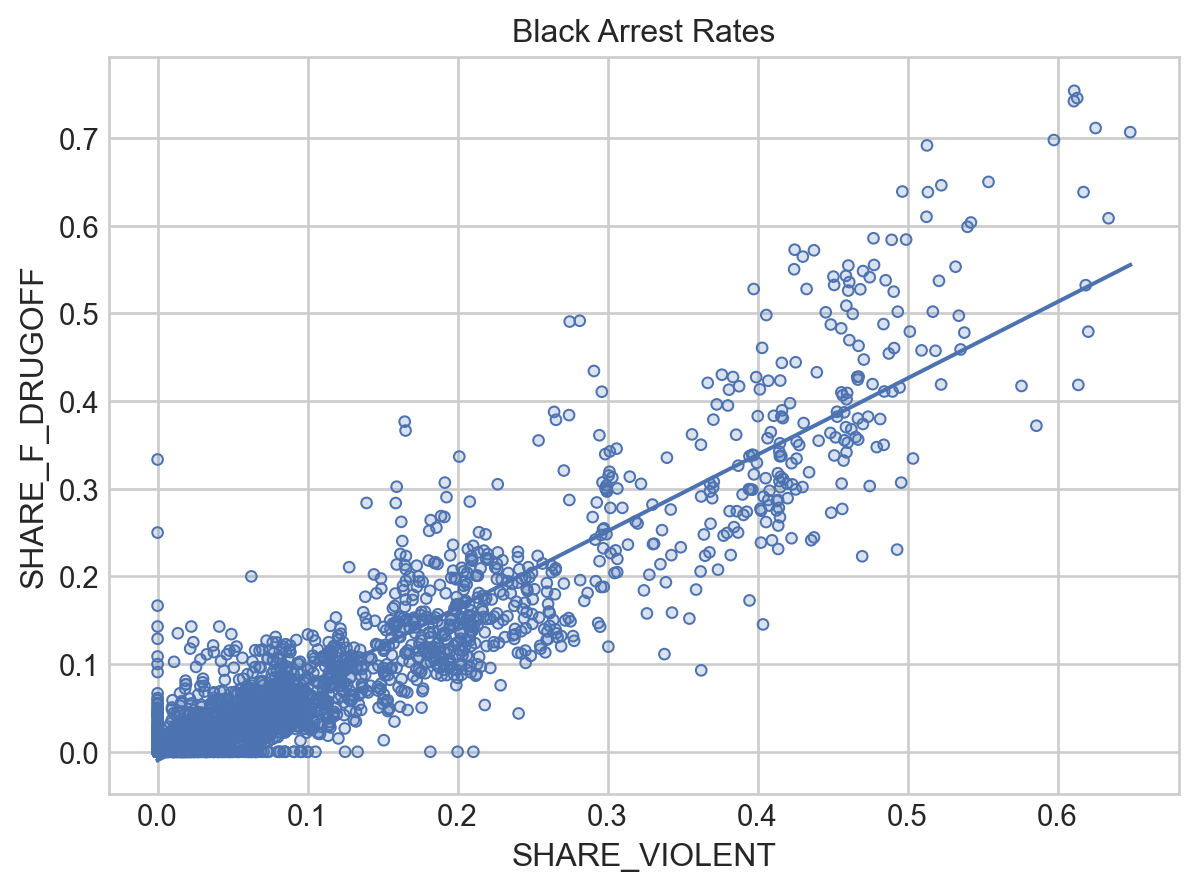

In [46]:
import seaborn.objects as so
from matplotlib import style
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

black_arrests = corrected_arrests[corrected_arrests.RACE == "Black"]
p = (
    so.Plot(black_arrests, x="SHARE_VIOLENT", y="SHARE_F_DRUGOFF")
    .add(so.Dots())
    .add(so.Lines(), so.PolyFit(order=1))
    .label(title="Black Arrest Rates")
    .theme({**style.library["seaborn-v0_8-whitegrid"]})
)
p

Proportionality is hard to see, so I'm gonna add a 45 degree line:

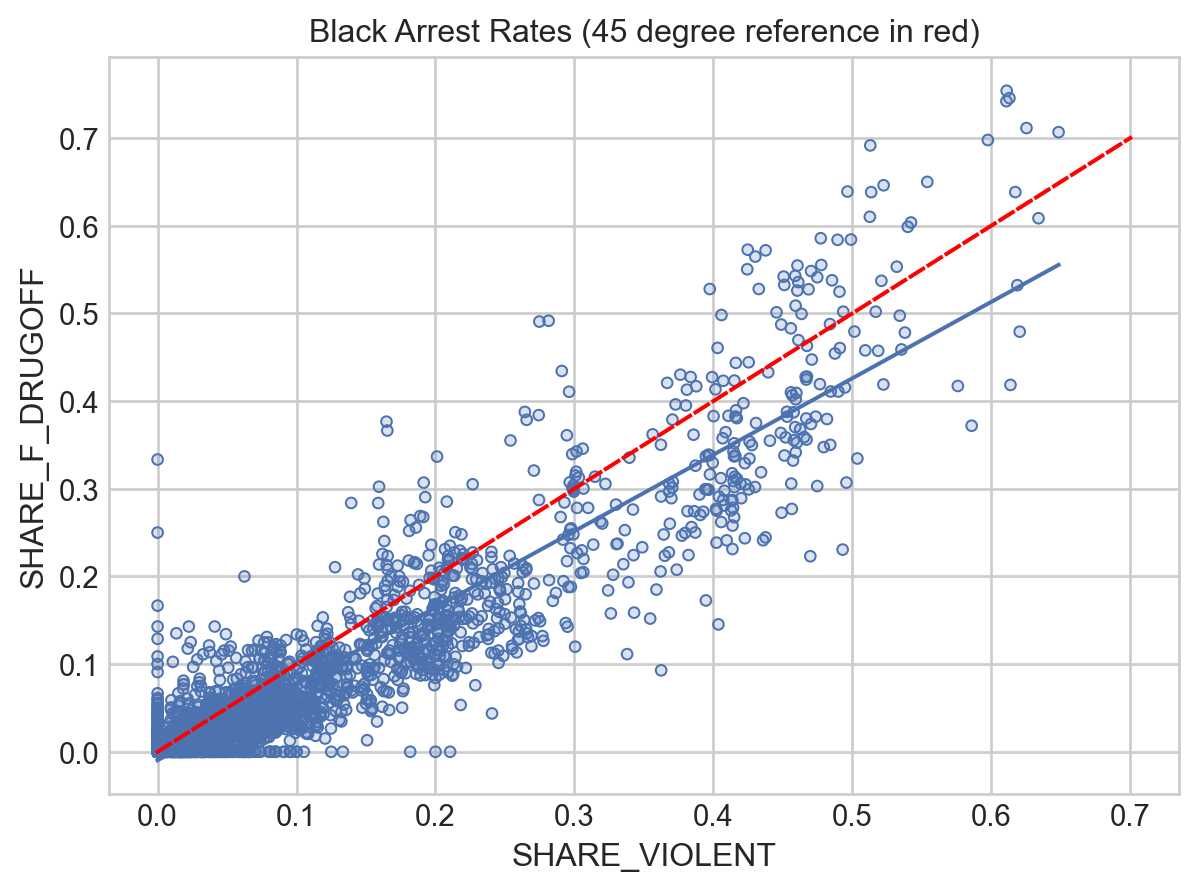

In [47]:
reference = pd.DataFrame({"SHARE_VIOLENT": [0, 0.7], "SHARE_F_DRUGOFF": [0, 0.7]})
p = (
    so.Plot(black_arrests, x="SHARE_VIOLENT", y="SHARE_F_DRUGOFF")
    .add(so.Dots())
    .add(so.Lines(), so.PolyFit(order=1))
    .add(so.Lines(color="red", linestyle="dashed"), so.PolyFit(order=1), data=reference)
    .label(title="Black Arrest Rates (45 degree reference in red)")
    .theme({**style.library["seaborn-v0_8-whitegrid"]})
)
p

Clearly this is below the line of proportionality, meaning that Black arrestees make up a larger share of violent arrestees than drug arrests.

In [48]:
results["ex12_proportionate"] = "greater violent"

(A quick note of warning on interpretation: these results can tell you whether Black Californians make up a larger proportion of *arrests* for certain types of crimes, not whether they make up a larger proportion of people who *commit* a give type of crime! Those *might* be the same, but they might not... this data just can't answer that question.)

In [49]:
results.keys()

dict_keys(['ex4_num_rows', 'ex5_collapsed_vars', 'ex7_alameda_1980_share_violent_arrestees_black', 'ex11_white_drug_share', 'ex11_black_drug_share', 'ex12_proportionate'])

In [50]:
assert set(results.keys()) == {
    "ex4_num_rows",
    "ex5_collapsed_vars",
    "ex7_alameda_1980_share_violent_arrestees_black",
    "ex11_white_drug_share",
    "ex11_black_drug_share",
    "ex12_proportionate",
}